In [2]:
%matplotlib inline
import numpy as np
import sklearn
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import timeit
import pandas as pd
import math
import itertools
import time

from sklearn.neighbors import (
    KernelDensity,
    KDTree,
)
from sklearn.preprocessing import (
    RobustScaler
)

In [34]:
df_combined = pd.read_csv("../../data/room.csv")

In [35]:
df_occ = df_combined[df_combined.Occupancy == 1]
df_un = df_combined[df_combined.Occupancy == 0]

In [36]:
len(df_occ)

4750

In [15]:
len(df_un)

15810

In [16]:
df_occ.describe()

,idx,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.0
mean,3793.241474,21.975909,28.076209,481.967380,975.321870,0.004589,1.0
std,2926.832245,0.817660,4.472351,94.704345,317.261466,0.000748,0.0
min,1.000000,19.500000,18.600000,0.000000,439.000000,0.002715,1.0
25%,1357.000000,21.500000,25.200000,433.000000,763.466667,0.004217,1.0
50%,2679.000000,21.890000,27.882000,454.000000,928.583333,0.004603,1.0
75%,7009.000000,22.340000,31.178750,481.575000,1120.500000,0.005049,1.0
max,9752.000000,24.408333,39.117500,1697.250000,2028.500000,0.006476,1.0


In [17]:
np.random.seed(0)
df_mixed = pd.concat([df_un,df_occ.sample(200, random_state=0)])
df_mixed["Light"] = df_mixed["Light"] + np.random.rand(len(df_mixed))
# mixed_data = df_mixed[["Temperature", "Humidity", "CO2", "Light", "HumidityRatio"]].values
mixed_data = df_mixed[["Temperature", "CO2"]].values

In [18]:
def estimate_kde_bw(data):
    q3 = np.percentile(data, 75, axis=0)
    q1 = np.percentile(data, 25, axis=0)
    iqr = q3 - q1
    bw = iqr * (data.shape[0])**(-1.0/(data.shape[1]+4))
    return bw

In [19]:
bw = estimate_kde_bw(mixed_data)
norm_data = mixed_data / bw

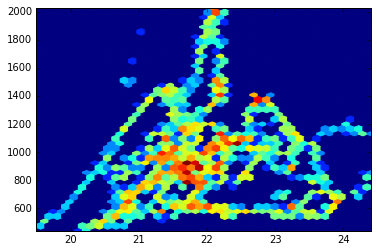

In [20]:
plt.hexbin(df_occ.Temperature, df_occ.CO2 ,gridsize=40,bins="log")

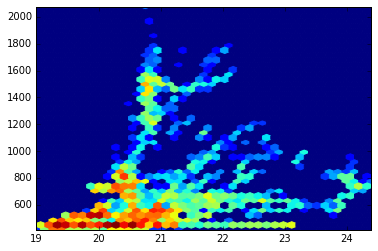

In [21]:
plt.hexbin(df_un.Temperature, df_un.CO2, gridsize=40,bins="log")

In [26]:
def eval_scores(df, scores):
    cutoff = np.percentile(scores, 99)
    outliers = scores > cutoff
    num_1 = sum(df[outliers])
    num_2 = sum(outliers)
    print("{}/{}".format(num_1, num_2))
    return outliers

# MCD

In [166]:
import sklearn.covariance

In [263]:
mcd = sklearn.covariance.MinCovDet(
    random_state=0,
)
mcd.fit(mixed_data)
mcd_scores = mcd.mahalanobis(mixed_data)
eval_scores(df_mixed.Occupancy, mcd_scores)

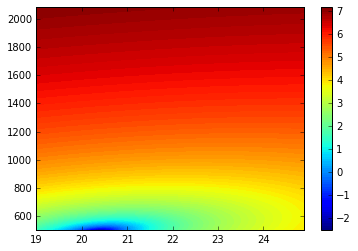

In [265]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=math.log(mcd.mahalanobis([[X[i,j],Y[i,j]]])[0])
plt.contourf(X,Y,Z,100)
plt.colorbar()

# Emp Cov

In [27]:
import sklearn.covariance

In [30]:
mcd = sklearn.covariance.EmpiricalCovariance(
)
mcd.fit(mixed_data)
mcd_scores = mcd.mahalanobis(mixed_data)
outliers = eval_scores(df_mixed.Occupancy, mcd_scores)

7/161


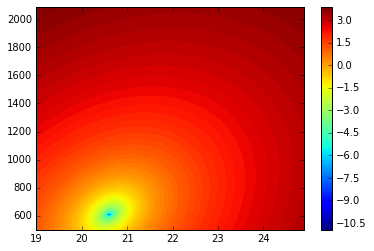

In [31]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=math.log(mcd.mahalanobis([[X[i,j],Y[i,j]]])[0])
plt.contourf(X,Y,Z,100)
plt.colorbar()

# KDE

In [32]:
tol = .1
kde = KernelDensity(
    bandwidth=.25,
    kernel='gaussian',
    algorithm='kd_tree',
    rtol=tol,
)
bw = estimate_kde_bw(mixed_data)
norm_data = mixed_data / bw
kde.fit(norm_data)
kde_scores = kde.score_samples(norm_data)
outliers = eval_scores(df_mixed.Occupancy, -kde_scores)

100/161


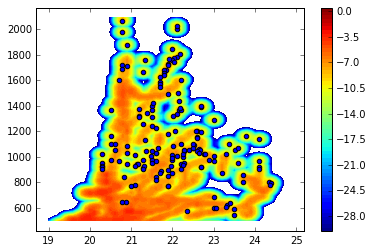

In [33]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=kde.score_samples([[X[i,j],Y[i,j]]] / bw)[0]
plt.figure()
plt.contourf(X,Y,Z,levels=np.arange(-30,1,.5))
plt.colorbar()
plt.scatter(mixed_data[outliers][:,0], mixed_data[outliers][:,1])

# GMM

In [271]:
import sklearn.mixture

In [355]:
np.random.seed(0)
gmm = sklearn.mixture.GMM(
    n_components=10,
    covariance_type="full",
    random_state=0,
)
gmm.fit(mixed_data)
gmm_scores,_ = gmm.score_samples(mixed_data)
outliers = eval_scores(df_mixed.Occupancy, -gmm_scores)

42/161


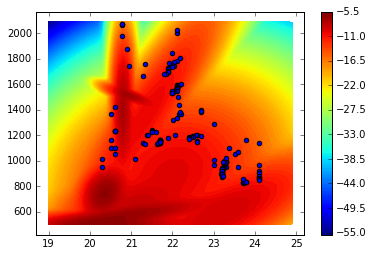

In [356]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=gmm.score_samples([[X[i,j],Y[i,j]]])[0]
plt.figure()
plt.contourf(X,Y,Z,100)
plt.colorbar()
plt.scatter(mixed_data[outliers][:,0], mixed_data[outliers][:,1])

# Random Forest

In [9]:
import sklearn.ensemble

In [31]:
forest = sklearn.ensemble.IsolationForest(
    contamination=.01,
    random_state=0,
)
forest.fit(mixed_data)
outliers = forest.predict(mixed_data) == -1
num_1 = sum(df_mixed.Occupancy[outliers])
num_2 = sum(outliers)
print("{}/{}".format(num_1, num_2))

21/162


# DBScan

In [57]:
import sklearn.cluster

In [81]:
dbs = sklearn.cluster.DBSCAN(
    eps=0.4,
    min_samples=4
)
clusters = dbs.fit_predict(norm_data)
outliers = (clusters == -1)
num_1 = sum(df_mixed.Occupancy[outliers])
num_2 = sum(outliers)
print("{}/{}".format(num_1, num_2))

95/162


# KNN

In [32]:
import sklearn.neighbors

In [35]:
tree = KDTree(
    norm_data
)

In [51]:
k=4
distances, _ = tree.query(norm_data, k=k)
knndistances = distances[:,k-1]
outliers = eval_scores(df_mixed.Occupancy, knndistances)

99/161
